<a href="https://www.kaggle.com/code/samyakb/feature-engineering-lgbm?scriptVersionId=159452396" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Whenever i submit, i get the message 'submission file not found', however when i run the code i am getting a submission file. Can someone please help me out?

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Read the data
X_full = pd.read_csv('/kaggle/input/playground-series-s4e1/train.csv', index_col='id')
X_test_full = pd.read_csv('/kaggle/input/playground-series-s4e1/test.csv', index_col='id')


In [2]:
X_full.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [3]:
# Feature engineering
X_full["Surname_First_Letter"] = X_full["Surname"].apply(lambda x: x[0])
X_test_full["Surname_First_Letter"] = X_test_full["Surname"].apply(lambda x: x[0])



X_full["Age_NumOfProducts"] = X_full["Age"] ** X_full["NumOfProducts"]
X_test_full["Age_NumOfProducts"] = X_test_full["Age"] ** X_test_full["NumOfProducts"]

## Risk Factors
X_full["Risk_Geography"] = X_full["Geography"].apply(lambda x: 1 if x == "Germany" else 0)
X_full["Risk_Age"] = X_full["Age"].apply(lambda x: 1 if x >= 40 else 0)
X_full["Risk_NumOfProducts"] = X_full["NumOfProducts"].apply(lambda x: 1 if x > 2 else 0)
X_full["RiskFactors"] = X_full["Risk_Geography"] + X_full["Risk_Age"] + X_full["Risk_NumOfProducts"]


X_test_full["Risk_Geography"] = X_test_full["Geography"].apply(lambda x: 1 if x == "Germany" else 0)
X_test_full["Risk_Age"] = X_test_full["Age"].apply(lambda x: 1 if x >= 40 else 0)
X_test_full["Risk_NumOfProducts"] = X_test_full["NumOfProducts"].apply(lambda x: 1 if x > 2 else 0)
X_test_full["RiskFactors"] = X_test_full["Risk_Geography"] + X_test_full["Risk_Age"] + X_test_full["Risk_NumOfProducts"]


X_full.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Surname_First_Letter,Age_NumOfProducts,Risk_Geography,Risk_Age,Risk_NumOfProducts,RiskFactors
id,,,,,,,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0,O,1089.0,0,0,0,0
1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0,O,1089.0,0,0,0,0
2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0,H,1600.0,0,1,0,1
3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0,K,34.0,0,0,0,0
4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0,C,1089.0,0,0,0,0


In [4]:
# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['Exited'], inplace=True)
y = X_full.Exited

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)



-------> Fold 1 <--------
: AUC ROC = 0.89713
-------> Fold 2 <--------
: AUC ROC = 0.89748
-------> Fold 3 <--------
: AUC ROC = 0.89937
-------> Fold 4 <--------
: AUC ROC = 0.89605
-------> Fold 5 <--------
: AUC ROC = 0.89619
--> Overall results for out of fold predictions
: AUC ROC = 0.89722


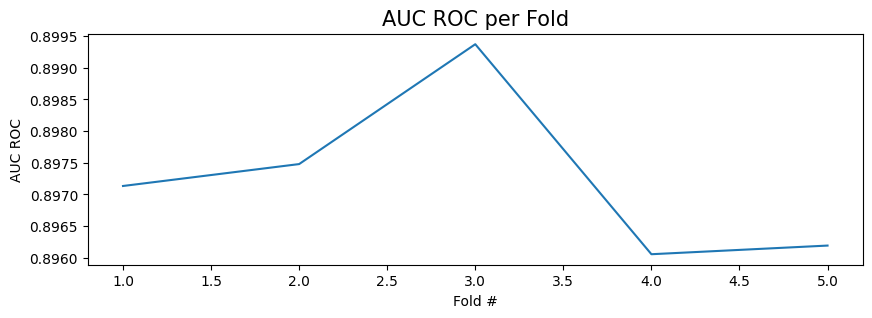

In [5]:
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from category_encoders.target_encoder import TargetEncoder

features = [
    'Surname', 'CreditScore', 'Geography', 'Gender',
    'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
    'IsActiveMember', 'EstimatedSalary','Surname_First_Letter',
    'Age_NumOfProducts','RiskFactors',
]

train_copy = X_full.copy()

for feature in ["Surname", "Geography", "Gender",'Surname_First_Letter']:
    te = TargetEncoder()
    train_copy[feature] = te.fit_transform(train_copy[feature], train_copy["Exited"])
    
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, random_state=2023, shuffle=True)
train_oof_preds = np.zeros((X_full.shape[0],))
scores = []

for fold, (train_index, test_index) in enumerate(skf.split(train_copy, train_copy["Exited"])):
    print(f"-------> Fold {fold+1} <--------")
    X_train_full, X_valid_full = pd.DataFrame(train_copy.iloc[train_index]), pd.DataFrame(train_copy.iloc[test_index])
    y_train, y_valid = train_copy["Exited"].iloc[train_index], train_copy["Exited"].iloc[test_index]
    
    x_train_features = pd.DataFrame(X_train_full[features])
    x_valid_features = pd.DataFrame(X_valid_full[features])

    model = LGBMClassifier(
        random_state=2023,
        objective="binary",
        metric="auc",
        n_jobs=-1,
        n_estimators=5000,
        verbose=-1,    
    )
    model.fit(
        x_train_features[features], 
        y_train,
        eval_set=[(x_valid_features[features], y_valid)],
        callbacks=[
            early_stopping(50, verbose=False),
            log_evaluation(5000),
        ]
    )
    oof_preds = model.predict_proba(x_valid_features[features])[:,1]
    train_oof_preds[test_index] = oof_preds
    score = roc_auc_score(y_valid, oof_preds)
    scores.append(score)
    print(f": AUC ROC = {score:.5f}")
    
auc_baseline = roc_auc_score(X_full["Exited"], train_oof_preds)
print("--> Overall results for out of fold predictions")
print(f": AUC ROC = {auc_baseline:.5f}")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))

data = pd.DataFrame({"Fold": [x + 1 for x in range(n_folds)], "AUC ROC": scores})
_ = sns.lineplot(x="Fold", y="AUC ROC", data=data, ax=ax)
_ = ax.set_title("AUC ROC per Fold", fontsize=15)
_ = ax.set_ylabel("AUC ROC")
_ = ax.set_xlabel("Fold #")


In [6]:
# features = [
#     'Surname', 'CreditScore', 'Geography', 'Gender',
#     'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
#     'IsActiveMember', 'EstimatedSalary','Surname_First_Letter',
#     'Age_NumOfProducts','Risk_Geography','Risk_Age','Risk_NumOfProducts','RiskFactors'
# ]


for feature in ["Surname", "Geography", "Gender",'Surname_First_Letter']:
    le = LabelEncoder()
    X_test_full[feature] = le.fit_transform(X_test_full[feature])
    
preds_test = model.predict(X_test_full[features])
# Save test predictions to file
output = pd.DataFrame({'id': X_test_full.index,
                       'Exited': preds_test})
output.to_csv('submission.csv', index=False)